Nunez seems to miss all the easy chances and score difficult ones, lets use xG as a metric for how "difficult" the chances are and compare shots scored vs missed

While looking for xG data I found this awesome source for xG data for each shot taken:

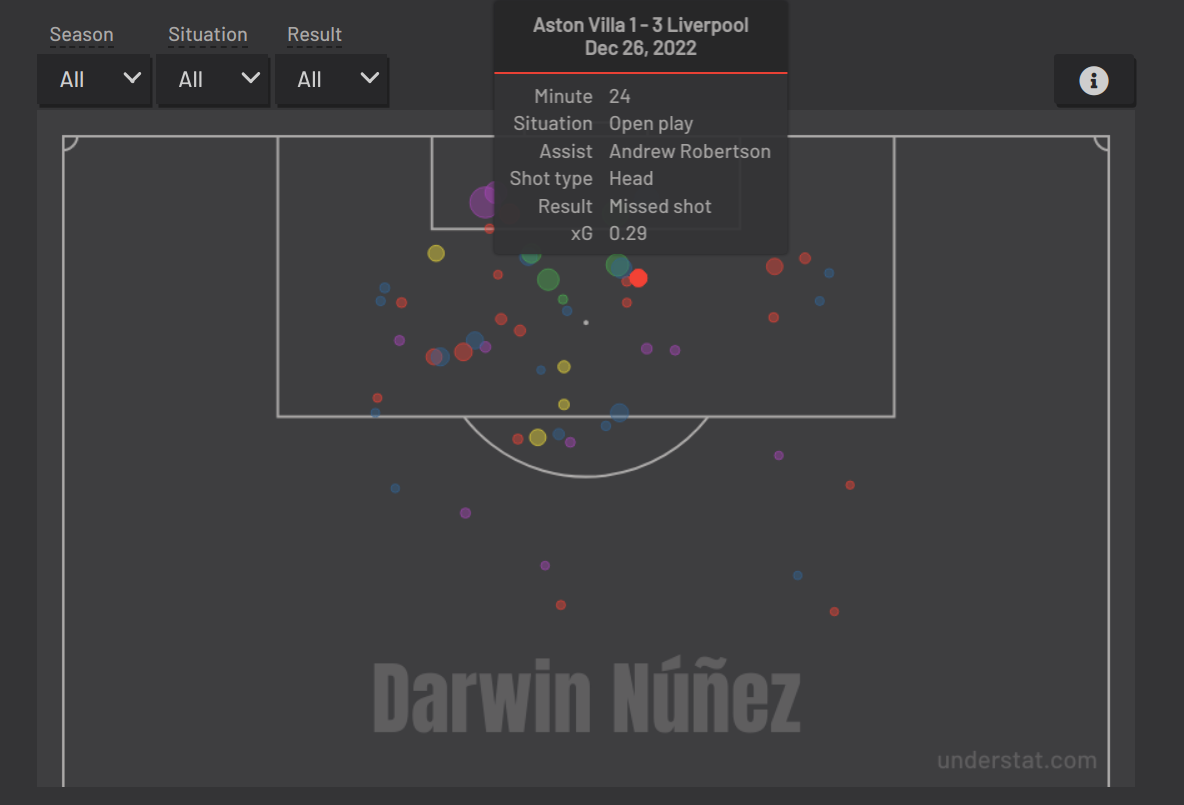

In [1]:
import os
import sys
from httpx import AsyncClient
module_path = os.path.abspath(os.path.join('../transfermarket/'))
sys.path.append(module_path)

In [2]:
nunez_id = '10720'
base_url = 'https://understat.com/player/'

client=AsyncClient()


curl request to mimic

```curl 'https://understat.com/player/10720' \
  -H 'authority: understat.com' \
  -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9' \
  -H 'accept-language: en-US,en;q=0.9' \
  -H 'cache-control: max-age=0' \
  -H 'cookie: PHPSESSID=f5c739c911d7d130ad9e5150ed5b8938; UID=a84486e18935c9cf; _ga=GA1.2.1581055568.1673124698; _gid=GA1.2.1765637446.1673124698; beget=begetok; _gat=1; PROMOTIONS=eyI3Ijp7InZpZXdzIjoyLCJjbGlja3MiOjB9LCJkYXRldGltZSI6MTY3MzEzMDg0ODM3MH0=' \
  -H 'referer: https://understat.com/team/Liverpool/2022' \
  -H 'sec-ch-ua: "Not?A_Brand";v="8", "Chromium";v="108", "Google Chrome";v="108"' \
  -H 'sec-ch-ua-mobile: ?0' \
  -H 'sec-ch-ua-platform: "Linux"' \
  -H 'sec-fetch-dest: document' \
  -H 'sec-fetch-mode: navigate' \
  -H 'sec-fetch-site: same-origin' \
  -H 'sec-fetch-user: ?1' \
  -H 'upgrade-insecure-requests: 1' \
  -H 'user-agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36' \
  --compressed```

In [3]:
res = await client.get(base_url)
res.content

b"<html><head><script>function set_cookie(){var now = new Date();var time = now.getTime();time += 19360000 * 1000;now.setTime(time);document.cookie='beget=begetok'+'; expires='+now.toGMTString()+'; path=/';}set_cookie();location.reload();;</script></head><body></body></html>\n"

In [4]:
# according to res above on inital request we have to do this lol
client.cookies.set("beget", "begetok")
nunez_page = await client.get(base_url+nunez_id)

In [5]:
import re
import json

shots_data = re.findall(b"var shotsData \t= JSON.parse\('(.*)'\)", nunez_page.content)[0]
shots = json.loads(shots_data.decode("unicode-escape"))

In [6]:
import pandas as pd
xg_df = pd.DataFrame(shots)

In [7]:
xg_df.columns

Index(['id', 'minute', 'result', 'X', 'Y', 'xG', 'player', 'h_a', 'player_id',
       'situation', 'season', 'shotType', 'match_id', 'h_team', 'a_team',
       'h_goals', 'a_goals', 'date', 'player_assisted', 'lastAction'],
      dtype='object')

<AxesSubplot: >

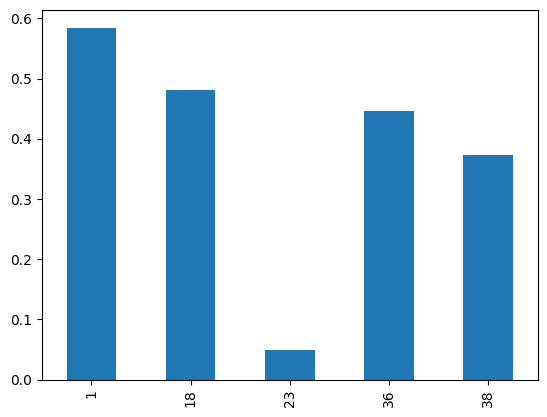

In [8]:
xg_df['xG'] = pd.to_numeric(xg_df['xG'])
xg_df[xg_df['result']=='Goal']['xG'].plot(kind='bar')

<AxesSubplot: >

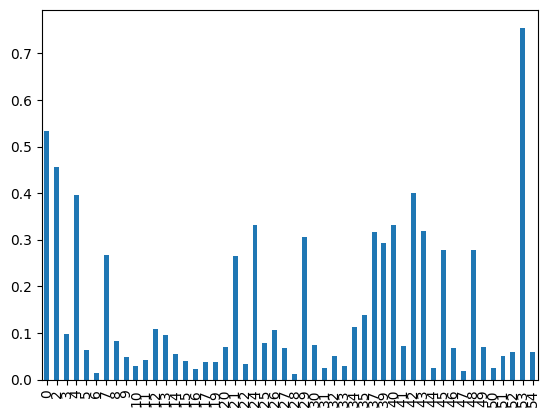

In [9]:
xg_df[xg_df['result']!='Goal']['xG'].plot(kind='bar')

In [10]:
xg_df= xg_df.reset_index(drop=True)

This looks like it'll work well for multiple players

<AxesSubplot: xlabel='xG', ylabel='player'>

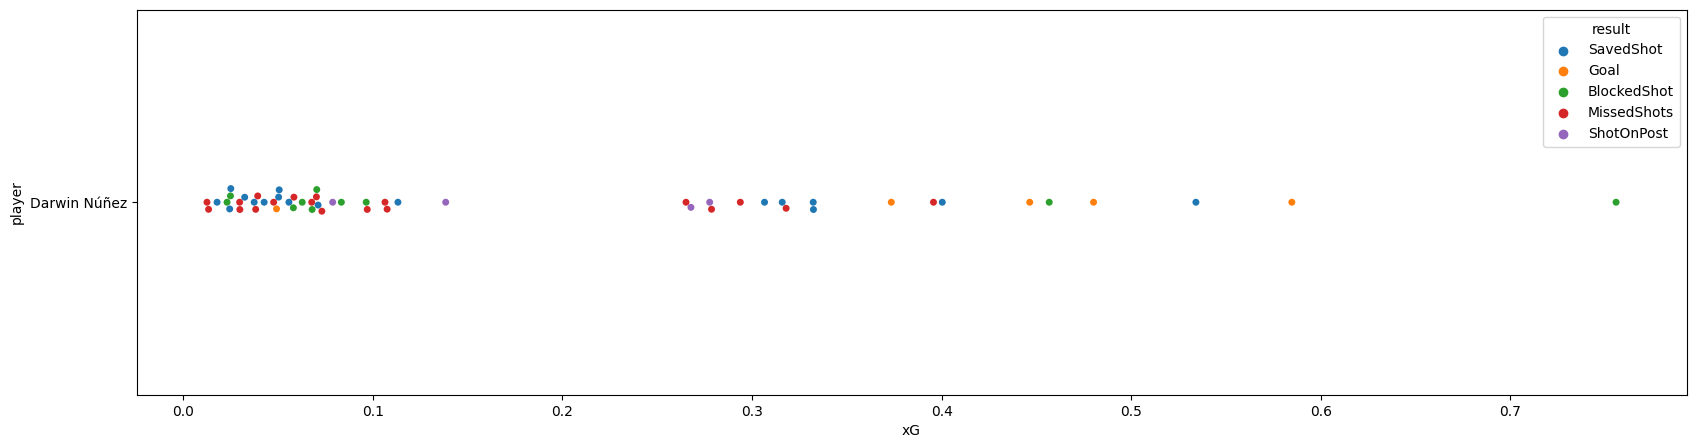

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5))

sns.swarmplot(xg_df,x= 'xG', y='player', hue='result')


Get rid of noise - lets just see goals vs non goal shots

In [12]:
xg_df['goal'] = xg_df.loc[:,'result'].apply(lambda x: x == 'Goal')
xg_df = xg_df[['player', 'xG', 'goal']]
xg_df.head()

,player,xG,goal
0,Darwin Núñez,0.534129,False
1,Darwin Núñez,0.584721,True
2,Darwin Núñez,0.456764,False
3,Darwin Núñez,0.097082,False
4,Darwin Núñez,0.395735,False


<AxesSubplot: xlabel='xG', ylabel='player'>

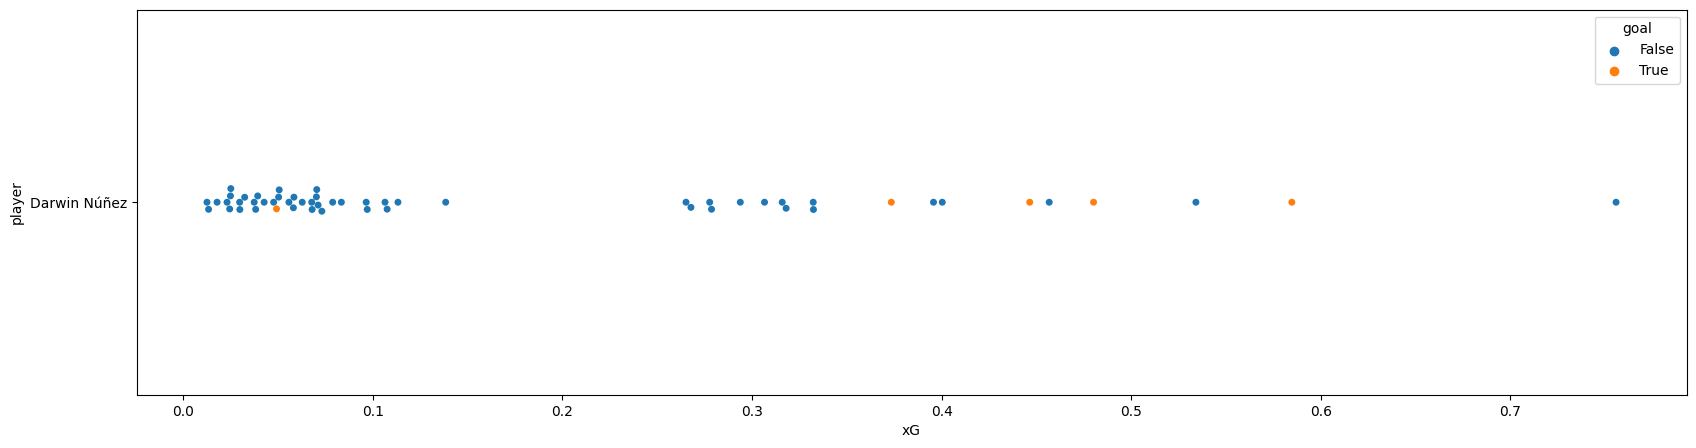

In [13]:
fig, ax = plt.subplots(figsize=(20,5))
sns.swarmplot(xg_df,x= 'xG', y='player', ax=ax, hue='goal')

Let's compare with some other forwards

In [14]:
res = await client.get("https://understat.com/league/EPL")

In [15]:
re.findall(b"var playersData\t= JSON.parse\((.*)\)", res.content)

[b"'\\x5B\\x7B\\x22id\\x22\\x3A\\x228260\\x22,\\x22player_name\\x22\\x3A\\x22Erling\\x20Haaland\\x22,\\x22games\\x22\\x3A\\x2216\\x22,\\x22time\\x22\\x3A\\x221324\\x22,\\x22goals\\x22\\x3A\\x2221\\x22,\\x22xG\\x22\\x3A\\x2215.81395536661148\\x22,\\x22assists\\x22\\x3A\\x223\\x22,\\x22xA\\x22\\x3A\\x223.7190108709037304\\x22,\\x22shots\\x22\\x3A\\x2265\\x22,\\x22key_passes\\x22\\x3A\\x2216\\x22,\\x22yellow_cards\\x22\\x3A\\x223\\x22,\\x22red_cards\\x22\\x3A\\x220\\x22,\\x22position\\x22\\x3A\\x22F\\x20S\\x22,\\x22team_title\\x22\\x3A\\x22Manchester\\x20City\\x22,\\x22npg\\x22\\x3A\\x2218\\x22,\\x22npxG\\x22\\x3A\\x2213.530448451638222\\x22,\\x22xGChain\\x22\\x3A\\x2215.309691175818443\\x22,\\x22xGBuildup\\x22\\x3A\\x220.9555932022631168\\x22\\x7D,\\x7B\\x22id\\x22\\x3A\\x22647\\x22,\\x22player_name\\x22\\x3A\\x22Harry\\x20Kane\\x22,\\x22games\\x22\\x3A\\x2218\\x22,\\x22time\\x22\\x3A\\x221614\\x22,\\x22goals\\x22\\x3A\\x2215\\x22,\\x22xG\\x22\\x3A\\x2211.978790000081062\\x22,\\x22assist

In [16]:
players_data = re.findall(b"var playersData\t= JSON.parse\('(.*)'\)", res.content)[0]
players = json.loads(players_data.decode("unicode-escape"))

In [17]:
players_5_goals = [player for player in players if int(player['goals'])>4]

In [18]:
player_ids = [player['id'] for player in players_5_goals]

In [19]:
import asyncio

fetch_coros = []
for player_id in player_ids:
    fetch_coros.append(client.get(base_url+player_id))

xg_responses = await asyncio.gather(*fetch_coros)


In [20]:
xg_data = []

for res in xg_responses:
    shots_data = re.findall(b"var shotsData \t= JSON.parse\('(.*)'\)", res.content)[0]
    shots = json.loads(shots_data.decode("unicode-escape"))
    xg_df = pd.DataFrame(shots)

    xg_data.append(xg_df)

In [21]:
all_shots = pd.concat(xg_data)

all_shots['xG'] = pd.to_numeric(all_shots['xG'])

In [22]:
all_shots['date'] = pd.to_datetime(all_shots['date'])

In [23]:
from datetime import datetime
all_shots_22_23 = all_shots[all_shots['date'] > datetime(2022,8,1)]

In [24]:
all_shots_22_23['goal'] = all_shots_22_23.loc[:,'result'].apply(lambda x: x == 'Goal')
all_shots_22_23 = all_shots_22_23.loc[:,['player', 'xG', 'goal']]
all_shots_22_23.head()

/tmp/ipykernel_18805/885059919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_shots_22_23['goal'] = all_shots_22_23.loc[:,'result'].apply(lambda x: x == 'Goal')


,player,xG,goal
205,Erling Haaland,0.484085,False
206,Erling Haaland,0.761169,True
207,Erling Haaland,0.328053,True
208,Erling Haaland,0.526608,False
209,Erling Haaland,0.066443,False


Looks a bit too crowded, lets remove some players

<AxesSubplot: xlabel='xG', ylabel='player'>

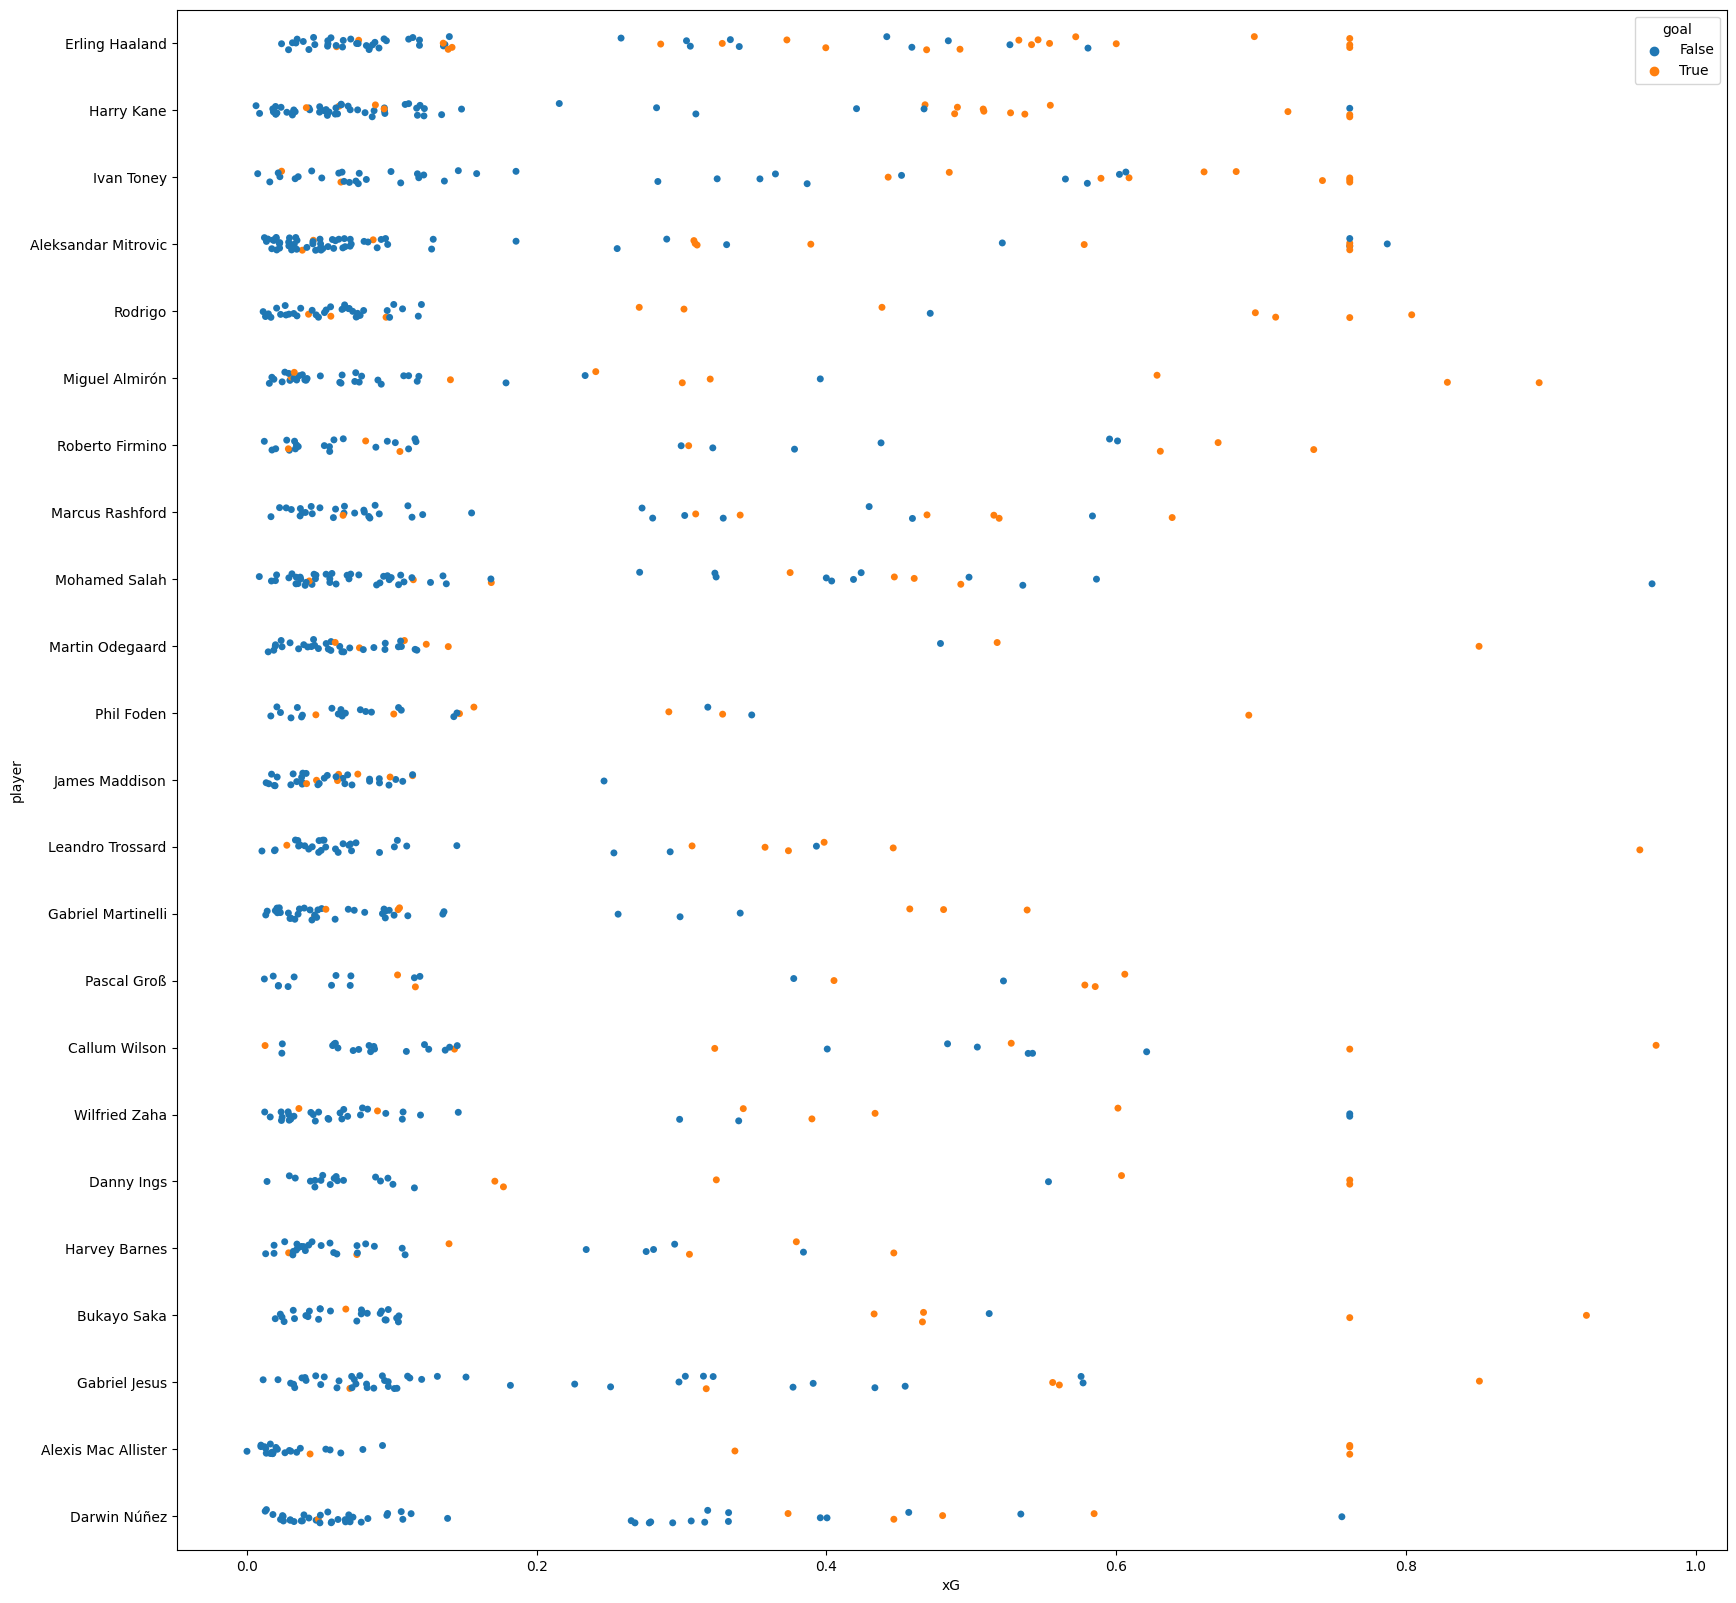

In [25]:
fig, ax = plt.subplots(figsize=(20,20))
sns.stripplot(all_shots_22_23,x= 'xG', y='player', hue='goal', ax=ax)

In [26]:
all_shots_22_23['player'].unique()

array(['Erling Haaland', 'Harry Kane', 'Ivan Toney',
       'Aleksandar Mitrovic', 'Rodrigo', 'Miguel Almirón',
       'Roberto Firmino', 'Marcus Rashford', 'Mohamed Salah',
       'Martin Odegaard', 'Phil Foden', 'James Maddison',
       'Leandro Trossard', 'Gabriel Martinelli', 'Pascal Groß',
       'Callum Wilson', 'Wilfried Zaha', 'Danny Ings', 'Harvey Barnes',
       'Bukayo Saka', 'Gabriel Jesus', 'Alexis Mac Allister',
       'Darwin Núñez'], dtype=object)

In [27]:
players = [
    'Darwin Núñez',
    'Mohamed Salah',
    'Roberto Firmino', 
    'Erling Haaland', 
    'Harry Kane',
    'Ivan Toney',
    'Marcus Rashford', 
    'Gabriel Jesus',
]
relevant_players = all_shots_22_23[all_shots_22_23['player'].apply(lambda x:x in players)]
relevant_players['order'] = relevant_players.loc[:,'player'].map({player:idx for idx, player in enumerate(players)})
relevant_players.sort_values('order', inplace=True)

/tmp/ipykernel_18805/3343156056.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_players['order'] = relevant_players.loc[:,'player'].map({player:idx for idx, player in enumerate(players)})
/tmp/ipykernel_18805/3343156056.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_players.sort_values('order', inplace=True)


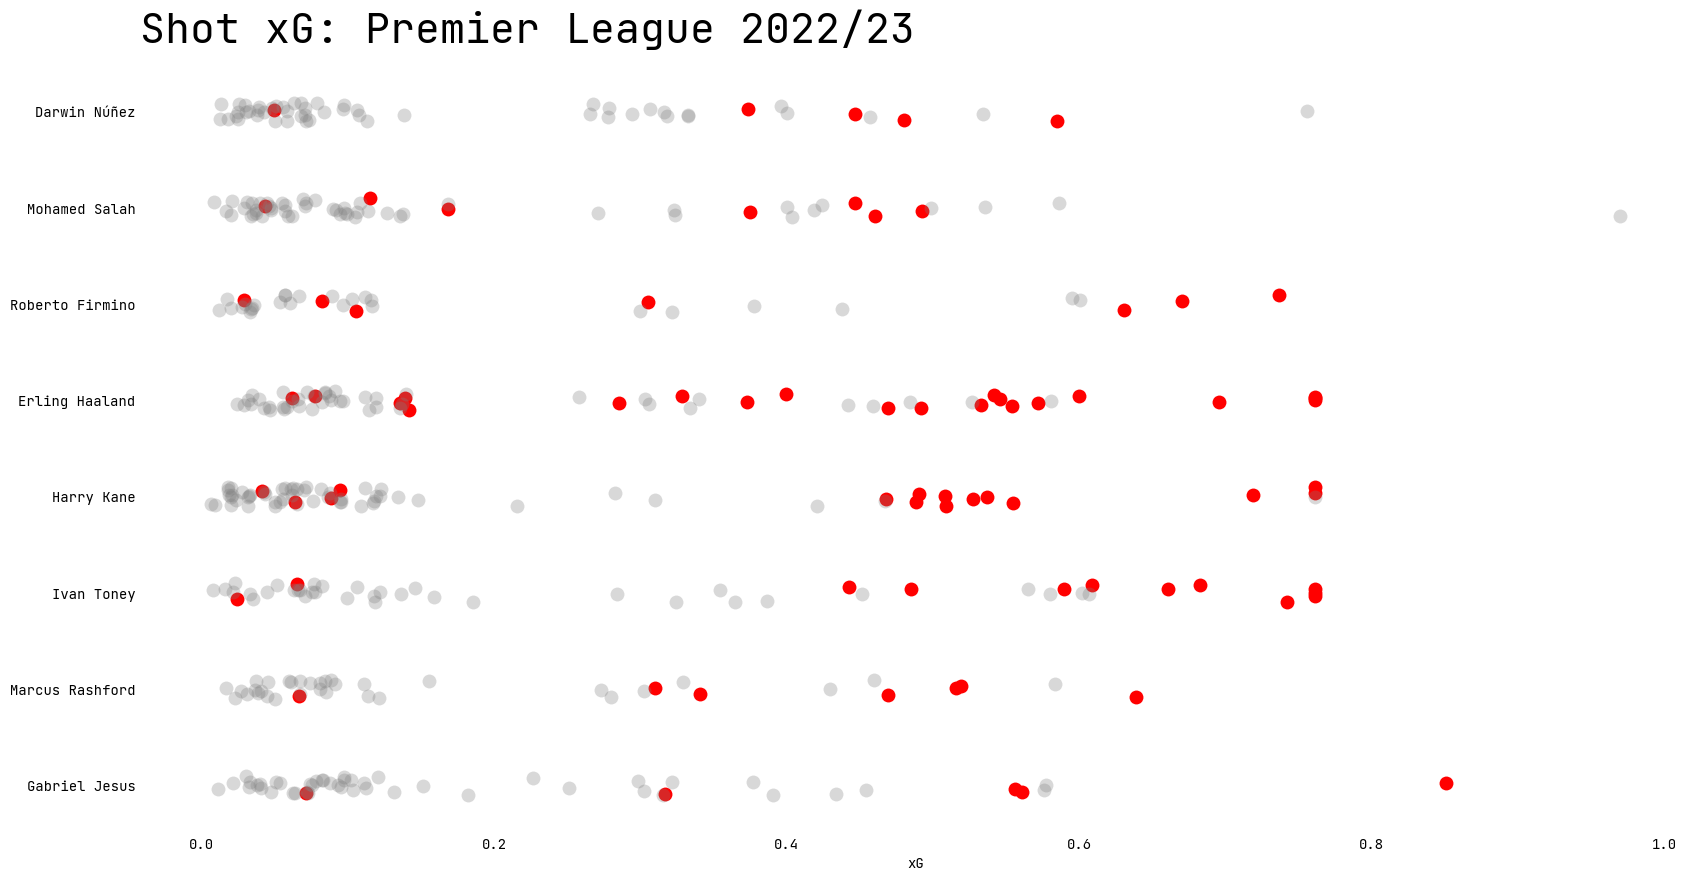

In [28]:
import matplotlib

matplotlib.rcParams['font.family'] = 'JetBrains Mono'
fig, ax = plt.subplots(figsize=(20,10))


sns.stripplot(relevant_players[relevant_players['goal']==True],x= 'xG', y='player', ax=ax, s=10, color='red')
sns.stripplot(relevant_players[relevant_players['goal']==False],x= 'xG', y='player', ax=ax, alpha=0.3, s=10, color='grey')

ax.tick_params(length=0)
ax.set_title("Shot xG: Premier League 2022/23", loc="left", pad=15, fontdict={'size':30})
ax.set_ylabel("")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

_ = ax.set_ylabel("")

Looks great, but for Darwin Nunez- 5 goals isn't really enough to draw a conclusion about the difficulty of the goals he scores.

fbref.com provides xG data for each shot including Champions League and Portuguese League (where Nunez played previous to joining Liverpoola) 

In [29]:
nunez_player_id = "4d77b365"
nunez_match_summary = f"https://fbref.com/en/players/{nunez_player_id}/matchlogs/2021-2022/summary/"

match_page = await client.get(nunez_match_summary)
matches = pd.read_html(match_page.content ,extract_links="all")[0].iloc[:, [0,4,5,6,7,-1]]
matches.columns = [(col[1][0]) for col in matches.columns] #type:ignore
# remove links for everything but match report
matches.iloc[:, :-1] = matches.iloc[:, :-1].applymap(lambda x:x[0])
matches.iloc[:, -1] = matches.iloc[:, -1].apply(lambda x:x[-1])

match_dates:dict[str, dict] = matches.dropna().set_index('Date').to_dict('index') #type:ignore

fbref limits you to 20 requests per minute so each request must be 3 seconds apart

https://www.sports-reference.com/bot-traffic.html

In [172]:
from time import sleep

data = await client.get(f"https://fbref.com/{match}")
sleep(int(data.headers.get('retry-after',0)))

In [173]:
fetch_coros = []
next_delay = 0

async def delayed_fetch(url:str,match_date:str,sleep_time_seconds:int = 3):
    global next_delay
    # need to increase the delay on each api request 
    # (since they all start the timers simulataneously)
    next_delay += sleep_time_seconds
    await asyncio.sleep(next_delay)
    
    print(".", end="")
    fetch = await client.get(url)
    # need to keep track of which match this is so we can add metadata
    # e.g. opponent name, match result
    return match_date, fetch

for date, match_details in match_dates.items():
    match_url = match_details['Match Report']
    fetch_coros.append(delayed_fetch(f"https://fbref.com/{match_url}", date))

match_pages = await asyncio.gather(*fetch_coros)

..............................................

In [174]:
match_data =[]
for match_date, data in match_pages:
    res = pd.read_html(data.content)[-1]
    shot_data = res.iloc[:,[0,1,3,5] ]
    shot_data= shot_data.droplevel(0, axis=1)
    shot_data['date'] = match_date
    match_data.append(shot_data)
    
all_matches = pd.concat(match_data)

In [189]:
print(f"total shots in dataset: {len(all_matches)}")

total shots in dataset: 462


In [183]:
nunez_shots = all_matches[all_matches['Player']=="Darwin Núñez"]

In [190]:
nunez_shots_match = pd.DataFrame.from_dict(match_dates, orient='index').join(nunez_shots.set_index('date'), how='right')

In [192]:
nunez_shots_match.head()

,Venue,Result,Squad,Opponent,Match Report,Minute,Player,xG,Outcome,Age,SoTA,Saves
2021-09-11,Away,W 5–0,Benfica,Santa Clara,/en/matches/92fc1957/Santa-Clara-Benfica-Septe...,54.0,Darwin Núñez,0.22,Goal,NaN,NaN,NaN
2021-09-11,Away,W 5–0,Benfica,Santa Clara,/en/matches/92fc1957/Santa-Clara-Benfica-Septe...,62.0,Darwin Núñez,0.03,Goal,NaN,NaN,NaN
2021-09-25,Away,W 3–1,Benfica,Vitória,/en/matches/18e7effd/Vitoria-Guimaraes-Benfica...,2.0,Darwin Núñez,0.02,Off Target,NaN,NaN,NaN
2021-09-25,Away,W 3–1,Benfica,Vitória,/en/matches/18e7effd/Vitoria-Guimaraes-Benfica...,13.0,Darwin Núñez,0.04,Blocked,NaN,NaN,NaN
2021-09-25,Away,W 3–1,Benfica,Vitória,/en/matches/18e7effd/Vitoria-Guimaraes-Benfica...,45.0,Darwin Núñez,0.21,Off Target,NaN,NaN,NaN


In [198]:
nunez_shots_match = nunez_shots_match.assign(is_goal = nunez_shots_match['Outcome']=='Goal')

This plot does show that Nunez scores a lot of low xG goals

<AxesSubplot: xlabel='xG'>

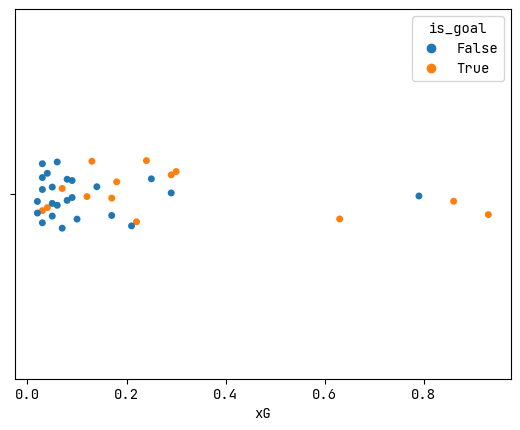

In [200]:
sns.stripplot(nunez_shots_match, x='xG', hue='is_goal')

In [201]:
nunez_shots_match[nunez_shots_match['is_goal']==True]

,Venue,Result,Squad,Opponent,Match Report,Minute,Player,xG,Outcome,Age,SoTA,Saves,is_goal
2021-09-11,Away,W 5–0,Benfica,Santa Clara,/en/matches/92fc1957/Santa-Clara-Benfica-Septe...,54.0,Darwin Núñez,0.22,Goal,NaN,NaN,NaN,True
2021-09-11,Away,W 5–0,Benfica,Santa Clara,/en/matches/92fc1957/Santa-Clara-Benfica-Septe...,62.0,Darwin Núñez,0.03,Goal,NaN,NaN,NaN,True
2021-11-02,Away,L 2–5,pt Benfica,de Bayern Munich,/en/matches/08db1510/Bayern-Munich-Benfica-Nov...,74.0,Darwin Núñez,0.63,Goal,NaN,NaN,NaN,True
2021-11-27,Away,W 7–0,Benfica,B-SAD,/en/matches/3606bc7a/Belenenses-SAD-Benfica-No...,32,Darwin Núñez,0.29,Goal,NaN,NaN,NaN,True
2021-11-27,Away,W 7–0,Benfica,B-SAD,/en/matches/3606bc7a/Belenenses-SAD-Benfica-No...,34,Darwin Núñez,0.86,Goal,NaN,NaN,NaN,True
2021-11-27,Away,W 7–0,Benfica,B-SAD,/en/matches/3606bc7a/Belenenses-SAD-Benfica-No...,45,Darwin Núñez,0.13,Goal,NaN,NaN,NaN,True
2021-12-12,Away,W 4–1,Benfica,Famalicão,/en/matches/b8636c3e/Famalicao-Benfica-Decembe...,6.0,Darwin Núñez,0.07,Goal,NaN,NaN,NaN,True
2021-12-12,Away,W 4–1,Benfica,Famalicão,/en/matches/b8636c3e/Famalicao-Benfica-Decembe...,14.0,Darwin Núñez,0.93,Goal,NaN,NaN,NaN,True
2021-12-12,Away,W 4–1,Benfica,Famalicão,/en/matches/b8636c3e/Famalicao-Benfica-Decembe...,56.0,Darwin Núñez,0.17,Goal,NaN,NaN,NaN,True
2022-02-07,Away,W 3–1,Benfica,Tondela,/en/matches/671b25ad/Tondela-Benfica-February-...,34,Darwin Núñez,0.04,Goal,NaN,NaN,NaN,True


Lets add in more data and cleanup the code so we can easily repeat this analysis and data collection for more players and seasons

In [243]:
from httpx import Response

nunez_player_id = "4d77b365"

async def get_match_data(player_id:str, season:str = '2022-2023')-> dict[str, dict[str,str]]:
    match_summary_url = f"https://fbref.com/en/players/{player_id}/matchlogs/{season}/summary/"

    match_page = await client.get(match_summary_url)
    matches = pd.read_html(match_page.content ,extract_links="all")[0].iloc[:, [0,4,5,6,7,-1]]
    matches.columns = [(col[1][0]) for col in matches.columns] #type:ignore
    # remove links for everything but match report
    matches.iloc[:, :-1] = matches.iloc[:, :-1].applymap(lambda x:x[0])
    matches.iloc[:, -1] = matches.iloc[:, -1].apply(lambda x:x[-1])

    match_dates:dict[str, dict] = matches.dropna().set_index('Date').to_dict('index') #type:ignore
    return match_dates

async def get_all_shots(match_dates:dict[str, dict[str,str]]):
    fetch_coros = []
    next_delay = 0

    async def delayed_fetch(url:str,match_date:str,sleep_time_seconds:int = 3)->tuple[str,Response]:
        nonlocal next_delay
        # need to increase the delay on each api request 
        # (since they all start the timers simulataneously)
        next_delay += sleep_time_seconds
        await asyncio.sleep(next_delay)
        
        print(".", end="")
        fetch = await client.get(url)
        # need to keep track of which match this is so we can add metadata
        # e.g. opponent name, match result
        return match_date, fetch

    for date, match_details in match_dates.items():
        match_url = match_details['Match Report']
        fetch_coros.append(delayed_fetch(f"https://fbref.com/{match_url}", date))

    match_pages = await asyncio.gather(*fetch_coros)
    return match_pages

def process_shot_data(match_pages:tuple[str,Response]):
    match_data =[]
    for match_date, data in match_pages:
        res = pd.read_html(data.content)[-1]
        if 'xG' not in pd.read_html(data.content)[-1].droplevel(level=0, axis=1).columns:
            print(match_date)
            continue
        shot_data = res.iloc[:,[0,1,3,5] ]
        shot_data= shot_data.droplevel(0, axis=1)
        shot_data['date'] = match_date
        match_data.append(shot_data)
        
    all_matches = pd.concat(match_data)
    return all_matches

In [204]:
nunez_23_matches = await get_match_data(nunez_player_id)

In [208]:
nunez_team_23_shots = await get_all_shots(nunez_23_matches)

............................

In [244]:
nunez_23_data = process_shot_data(nunez_team_23_shots)

2022-07-30
2022-09-23
2022-09-27
2022-11-09
2022-12-22
2023-01-07


In [248]:
nunez_23_data[(nunez_23_data['date']=='2022-11-12')]
    

,Minute,Player,xG,Outcome,date
0,2.0,Che Adams,0.23,Off Target,2022-11-12
1,9.0,Che Adams,0.26,Goal,2022-11-12
2,12.0,Romain Perraud,0.03,Blocked,2022-11-12
3,40.0,Adam Armstrong,0.07,Off Target,2022-11-12
4,NaN,NaN,NaN,NaN,2022-11-12
5,47.0,Adam Armstrong,0.04,Saved,2022-11-12
6,54.0,Adam Armstrong,0.05,Off Target,2022-11-12
7,62.0,Mohamed Elyounoussi,0.06,Saved,2022-11-12
8,63.0,Samuel Edozie,0.22,Saved,2022-11-12
9,77.0,Che Adams,0.10,Saved,2022-11-12


In [241]:
nunez_23_matches['2022-11-12']

{'Venue': 'Home',
 'Result': 'W 3–1',
 'Squad': 'Liverpool',
 'Opponent': 'Southampton',
 'Match Report': '/en/matches/1579d34b/Liverpool-Southampton-November-12-2022-Premier-League'}

In [249]:
southampton_edge_case = await get_all_shots({'2022-11-12':nunez_23_matches['2022-11-12']})

.

In [261]:
match_data =[]
for match_date, data in southampton_edge_case:
    res_dfs = pd.read_html(data.content)

    longest_xg_df = 0
    xg_df = None
    #we need to find xg table with most entries (to ensure we arent picking a filtered table)
    for df in res_dfs:
        try:
            if 'xG' in df.droplevel(level=0, axis=1).columns:
                if len(df) > longest_xg_df:
                    longest_xg_df = len(df)
                    xg_df = df
        except ValueError:
            # we cant drop level so this isnt an xg table
            continue
    shot_data = res.iloc[:,[0,1,3,5] ]
    shot_data= shot_data.droplevel(0, axis=1)
    shot_data['date'] = match_date
    match_data.append(shot_data)

This now gives us the correct table with all shots (not filtered for a team)

In [263]:
xg_df

Unnamed: 0_level_0      Unnamed: 1_level_0 Unnamed: 2_level_0  \
               Minute                  Player              Squad   
0                   2               Che Adams        Southampton   
1                   6         Roberto Firmino          Liverpool   
2                   9               Che Adams        Southampton   
3                  12          Romain Perraud        Southampton   
4                  16           Mohamed Salah          Liverpool   
5                  21            Darwin Núñez          Liverpool   
6                  30         Roberto Firmino          Liverpool   
7                  31            Darwin Núñez          Liverpool   
8                  32           Mohamed Salah          Liverpool   
9                  35  Trent Alexander-Arnold          Liverpool   
10                 40          Adam Armstrong        Southampton   
11                 42            Darwin Núñez          Liverpool   
12                NaN                     NaN                NaN   
13                 47          Adam Armstrong        Southampton   
14                 50         Roberto Firmino          Liverpool   
15                 54          Adam Armstrong        Southampton   
16                 55           Mohamed Salah          Liverpool   
17                 62     Mohamed Elyounoussi        Southampton   
18                 63           Samuel Edozie        Southampton   
19                 72         Virgil van Dijk          Liverpool   
20                 77               Che Adams        Southampton   
21                 82                 Fabinho          Liverpool   
22                 88         Virgil van Dijk          Liverpool   
23               90+2           Mohamed Salah          Liverpool   
24               90+3         Virgil van Dijk          Liverpool   

   Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0  \
                   xG               PSxG            Outcome   
0                0.23                NaN         Off Target   
1                0.02               0.15               Goal   
2                0.26               0.08               Goal   
3                0.03                NaN            Blocked   
4                0.34               0.31              Saved   
5                0.36               0.95               Goal   
6                0.17               0.22              Saved   
7                0.09               0.51              Saved   
8                0.13               0.08              Saved   
9                0.04                NaN         Off Target   
10               0.07                NaN         Off Target   
11               0.26               0.76               Goal   
12                NaN                NaN                NaN   
13               0.04               0.04              Saved   
14               0.04                NaN         Off Target   
15               0.05                NaN         Off Target   
16               0.18                NaN         Off Target   
17               0.06               0.54              Saved   
18               0.22               0.46              Saved   
19               0.03                NaN         Off Target   
20               0.10               0.02              Saved   
21               0.05                NaN         Off Target   
22               0.07                NaN         Off Target   
23               0.13                NaN            Blocked   
24               0.03                NaN            Blocked   

   Unnamed: 6_level_0 Unnamed: 7_level_0 Unnamed: 8_level_0  \
             Distance          Body Part              Notes   
0                 9.0               Head                NaN   
1                16.0               Head                NaN   
2                 9.0               Head                NaN   
3                18.0          Left Foot             Volley   
4                 9.0         Right Foot                NaN   
5                10.0  

Update the function

In [282]:
def process_shot_data(match_pages:tuple[str,Response]):
    match_data =[]
    for match_date, data in match_pages:
        res_dfs = pd.read_html(data.content)

        longest_xg_df = 0
        xg_df = None
        #we need to find xg table with most entries (to ensure we arent picking a filtered table)
        for df in res_dfs:
            try:
                if 'xG' in df.droplevel(level=0, axis=1).columns:
                    if len(df) > longest_xg_df:
                        longest_xg_df = len(df)
                        xg_df = df
            except ValueError:
                # we cant drop level so this isnt an xg table
                continue
    
        if xg_df is None:
            # no xg data available for this game
            continue
        shot_data = xg_df.iloc[:,[0,1,3,5] ]
        shot_data= shot_data.droplevel(0, axis=1)
        shot_data['date'] = match_date
        match_data.append(shot_data)
        
    all_matches = pd.concat(match_data)
    return all_matches

In [283]:
nunez_23_data = process_shot_data(nunez_team_23_shots)

In [291]:
nunez_shots = nunez_23_data[(nunez_23_data['Player']=='Darwin Núñez')]# & (nunez_23_data['Outcome']=='Goal')]

In [293]:
nunez_shots_matches_23 = pd.DataFrame.from_dict(nunez_23_matches, orient='index').join(nunez_shots.set_index('date'), how='right')

In [296]:
nunez_shots_matches_23 = nunez_shots_matches_23.assign(is_goal = nunez_shots_matches_23['Outcome']=='Goal')

<AxesSubplot: xlabel='xG'>

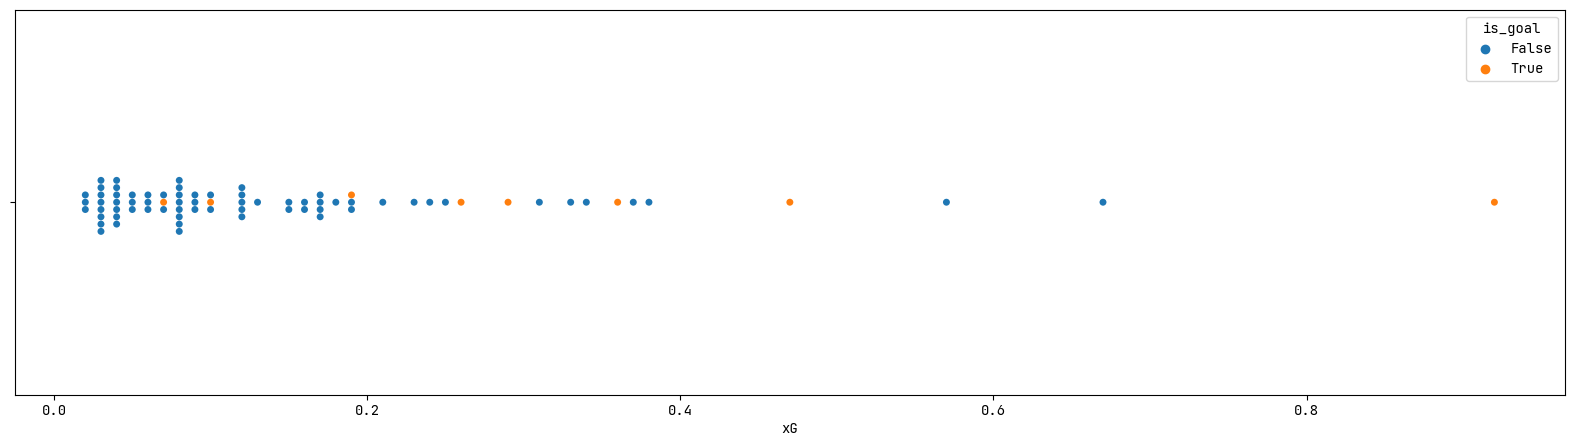

In [300]:
fig, ax = plt.subplots(figsize=(20,5))
sns.swarmplot(nunez_shots_matches_23, x='xG', hue='is_goal')

In [302]:
nunez_shots_matches_23[nunez_shots_matches_23['Outcome']=='Goal']

,Venue,Result,Squad,Opponent,Match Report,Minute,Player,xG,Outcome,is_goal
2022-08-06,Away,D 2–2,Liverpool,Fulham,/en/matches/6713c1dc/Fulham-Liverpool-August-6...,64,Darwin Núñez,0.29,Goal,True
2022-10-09,Away,L 2–3,Liverpool,Arsenal,/en/matches/84a48413/Arsenal-Liverpool-October...,34,Darwin Núñez,0.47,Goal,True
2022-10-12,Away,W 7–1,eng Liverpool,sct Rangers,/en/matches/b79490f8/Rangers-Liverpool-October...,66,Darwin Núñez,0.19,Goal,True
2022-10-19,Home,W 1–0,Liverpool,West Ham,/en/matches/dba5c5ec/Liverpool-West-Ham-United...,22,Darwin Núñez,0.07,Goal,True
2022-10-26,Away,W 3–0,eng Liverpool,nl Ajax,/en/matches/d88e832b/Ajax-Liverpool-October-26...,49,Darwin Núñez,0.10,Goal,True
2022-11-01,Home,W 2–0,eng Liverpool,it Napoli,/en/matches/91efb39a/Liverpool-Napoli-November...,90+8,Darwin Núñez,0.92,Goal,True
2022-11-12,Home,W 3–1,Liverpool,Southampton,/en/matches/1579d34b/Liverpool-Southampton-Nov...,21,Darwin Núñez,0.36,Goal,True
2022-11-12,Home,W 3–1,Liverpool,Southampton,/en/matches/1579d34b/Liverpool-Southampton-Nov...,42,Darwin Núñez,0.26,Goal,True


Compare with plot from understat data (only premier league data):

## Understat.com
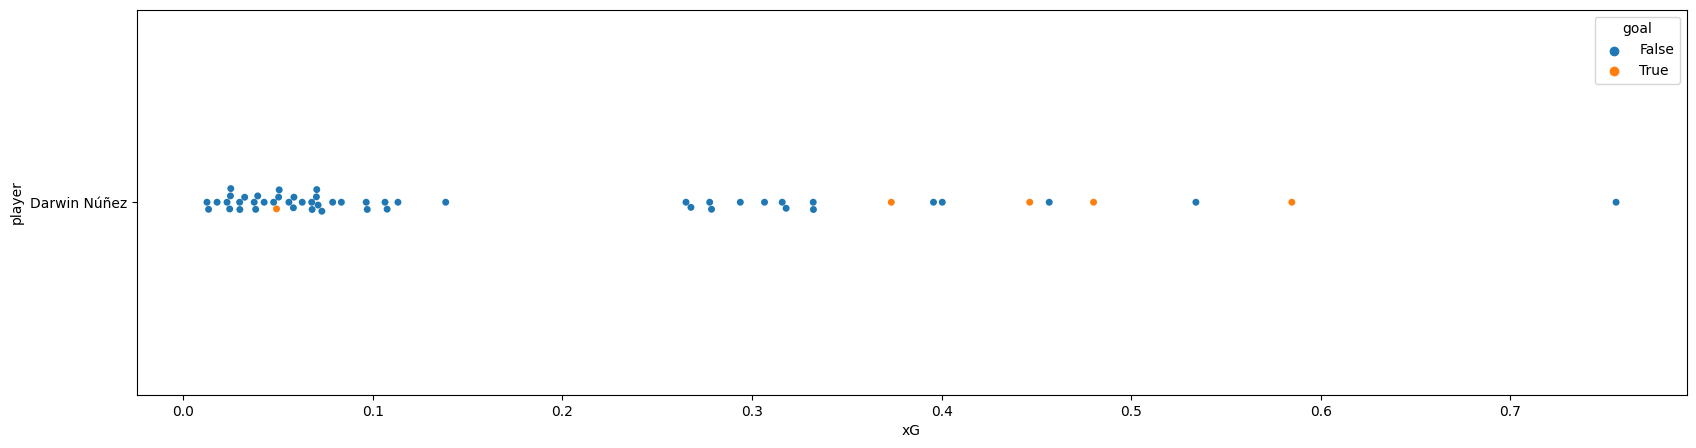

Understat predicts higher xG than fbref, but since fbref has more data - we'll use it going forward for other players

#TDOD scrape liverpool shots data (we'll get all lpool data for free by scraping one player)

#TODO scrape other striker data: Haaland, Kane